# Instructor Do: RNNs for NLP - Sentiment Analysis

In this activity, students will learn how to define a LSTM RNN model for sentiment analysis using Keras. Also, data preparation for using LSTM models for natural language processing is introduced.

In [1]:
# Initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from path import Path

%matplotlib inline

## The Dataset

The provided data file contains `6878` customer reviews of Coffee Shops at Austin, Texas. The reviews were taken from Yelp; however, the names of the Coffee Shops were anonymized for privacy reasons.

The dataset has the following columns:

* `coffee_shop_name`: The anonymized name of the coffee shop.

* `full_review_text`: The customers reviews.

* `sentiment`: The sentiment of each customer's review. `0` - Negative, `1` - Positive.

In [2]:
# Import the dataset
file_path = Path("../Resources/austin_coffee_shops_reviews.csv")
reviews_df = pd.read_csv(file_path)
reviews_df.head()

coffee_shop_name                                   full_review_text  \
0   Coffee Shop 66  Love love loved the atmosphere! Every corner o...   
1   Coffee Shop 66  Listed in Date Night: Austin, Ambiance in Aust...   
2   Coffee Shop 66  Listed in Brunch Spots I loved the eclectic an...   
3   Coffee Shop 66  Very cool decor! Good drinks Nice seating  How...   
4   Coffee Shop 66  They are located within the Northcross mall sh...   

   sentiment  
0          1  
1          1  
2          1  
3          0  
4          1

## Data Preprocessing

RNN input requires an array data type. The `full_review_text` column will be transformed into the `X` array and the “sentiment” column into the `y` array.

In [3]:
# Creating the X and y vectors
X = reviews_df["full_review_text"].values
y = reviews_df["sentiment"].values

To train the RNN model, we need to encode the text data as an integer. This transformation can be done using the following tools from Keras.

In [4]:
# Import Keras modules for data encoding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# Create an instance of the Tokenizer and fit it with the X text data
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)

In [6]:
# Print the first five elements of the encoded vocabulary
for token in list(tokenizer.word_index)[:5]:
    print(f"word: '{token}', token: {tokenizer.word_index[token]}")

word: 'the', token: 1
word: 'and', token: 2
word: 'a', token: 3
word: 'i', token: 4
word: 'to', token: 5


In [7]:
# Transform the text data to numerical sequences
X_seq = tokenizer.texts_to_sequences(X)

# Contrast a sample numerical sequence with its text version
print(f"**Text comment** \n {X[0]} \n")
print(f"**Numerical sequence representation** \n {X_seq[0]}")

**Text comment** 
 Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes!  I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas? 

**Numerical sequence representation** 
 [53, 53, 301, 1, 114, 188, 589, 6, 1, 8, 65, 29, 255, 351, 810, 2, 36, 50, 1138, 4, 125, 1, 511, 69, 2, 11, 10, 5621, 5019, 506, 2, 319, 16, 106, 50, 89, 4562, 4, 125, 21, 58, 1112, 68, 1909, 40, 967, 998, 18, 5020, 43, 8, 5, 416, 3656, 1018, 6, 732, 2, 3, 4563, 1289, 4, 90, 16, 69, 999, 312, 4, 10, 1364, 12, 3, 811, 652, 39, 5622, 21, 16, 69, 17, 302, 474, 4202, 38, 40, 1, 4203, 6, 71, 1, 368, 439

The RNN model requires that all the values of the `X` vector have the same length; the `pad_sequences` method will ensure that all integer encoded reviews have the same size. Each entry in `X` will be shortened to `140` integers, or pad with `0's` in case it's shorter.

In [8]:
# Padding sequences
X_pad = pad_sequences(X_seq, maxlen=140, padding="post")

Now that the data is encoded, the training, validation, and testing sets will be created.

In [9]:
# Creating training, validation, and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, random_state=78)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=78)

## Build and Train the LSTM RNN Model

In this section, a custom LSTM RNN model is going to be designed in Keras, and it's going to be fitted (trained) using the training data we defined.

These are the steps that will be followed:

* Define the model architecture in Keras.

* Compile the model.

* Fit the model to the training data.

### Importing the Keras Modules

To build an LSTM RNN model in Keras, the `Sequential` model is used as it have been done before; however, there are two new types of layers that are needed:

* `Embeding`: It's a type of layer that is used in neural networks to process encoded text data.

* `LSTM`: It's used to add an LSTM layer to the model.

In [10]:
# Import Keras modules for model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

### Setting Up the Model

The `Embedding` layer requires as parameter the size of the vocabulary in the text that is going to be processed. The `vocabulary_size` is set at the total number of words in the `tokenizer` dictionary plus `1`. The other parameter needed by this layer is the `input_length`; this parameter is set at `140` (`max_words` variable) that is the value defined for padding the reviews.

The `embedding_size` parameter specifies how many dimensions will be used to represent each word. As a rule-of-thumb, a multiple of eight could be used; for this demo, tuning the model value `64` delivered the best result.

In [11]:
# Model set-up
vocabulary_size = len(tokenizer.word_counts.keys()) + 1
max_words = 140
embedding_size = 64

### Defining the Model's Structure

In [12]:
# Define the LSTM RNN model
model = Sequential()

# Layer 1
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

# Layer 2
model.add(LSTM(units=280))

# Output layer
model.add(Dense(1, activation="sigmoid"))

### Compiling the Model

In [13]:
# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

In [14]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 64)           1091264   
_________________________________________________________________
lstm (LSTM)                  (None, 280)               386400    
_________________________________________________________________
dense (Dense)                (None, 1)                 281       
Total params: 1,477,945
Trainable params: 1,477,945
Non-trainable params: 0
_________________________________________________________________


### Training the Model

In [15]:
# Training the model
batch_size = 1000
training_history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=batch_size,
    verbose=1,
)

Train on 3868 samples, validate on 1290 samples
Epoch 1/10
3868/3868 [==============================] - 20s 5ms/sample - loss: 0.6375 - accuracy: 0.8710 - tp: 3351.0000 - tn: 18.0000 - fp: 391.0000 - fn: 108.0000 - precision: 0.8955 - recall: 0.9688 - auc: 0.5010 - val_loss: 0.4469 - val_accuracy: 0.8938 - val_tp: 1153.0000 - val_tn: 0.0000e+00 - val_fp: 137.0000 - val_fn: 0.0000e+00 - val_precision: 0.8938 - val_recall: 1.0000 - val_auc: 0.5932
Epoch 2/10
3868/3868 [==============================] - 15s 4ms/sample - loss: 0.4141 - accuracy: 0.8943 - tp: 3459.0000 - tn: 0.0000e+00 - fp: 409.0000 - fn: 0.0000e+00 - precision: 0.8943 - recall: 1.0000 - auc: 0.5337 - val_loss: 0.3918 - val_accuracy: 0.8938 - val_tp: 1153.0000 - val_tn: 0.0000e+00 - val_fp: 137.0000 - val_fn: 0.0000e+00 - val_precision: 0.8938 - val_recall: 1.0000 - val_auc: 0.6005
Epoch 3/10
3868/3868 [==============================] - 14s 4ms/sample - loss: 0.3806 - accuracy: 0.8943 - tp: 3459.0000 - tn: 0.0000e+00 - fp:

### Model Performance

#### Checking Training History

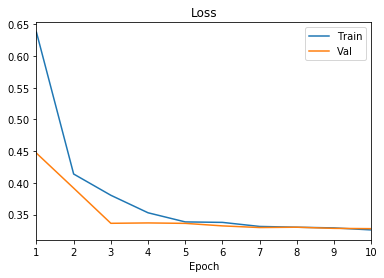

In [16]:
# Plottig loss
loss_df = pd.DataFrame(
    {
        "Epoch": range(1, 11),
        "Train": training_history.history["loss"],
        "Val": training_history.history["val_loss"],
    }
)
loss_df.set_index("Epoch", inplace=True)
loss_df.plot(title="Loss")

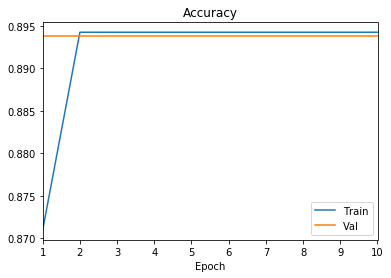

In [17]:
# Plottig accuracy
accuracy_df = pd.DataFrame(
    {
        "Epoch": range(1, 11),
        "Train": training_history.history["accuracy"],
        "Val": training_history.history["val_accuracy"],
    }
)
accuracy_df.set_index("Epoch", inplace=True)
accuracy_df.plot(title="Accuracy")

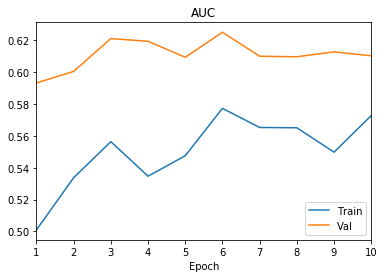

In [18]:
# Plottig AUC
auc_df = pd.DataFrame(
    {
        "Epoch": range(1, 11),
        "Train": training_history.history["auc"],
        "Val": training_history.history["val_auc"],
    }
)
auc_df.set_index("Epoch", inplace=True)
auc_df.plot(title="AUC")

#### Plotting the ROC Curve

In [27]:
# Create a function to plot the ROC Curve
from sklearn.metrics import roc_curve

def plot_roc(name, labels, predictions, **kwargs):
    fpr, tpr, thresholds = roc_curve(labels, predictions)

    plt.plot(fpr, tpr, label=name, linewidth=2, **kwargs)
    plt.xlabel("False positives rate")
    plt.ylabel("True positives rate")
    plt.title("ROC Curve")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect("equal")

In [31]:
# Making predictions to feed the roc_curve module
train_predictions = model.predict(X_train, batch_size=1000)
test_predictions = model.predict(X_test, batch_size=1000)

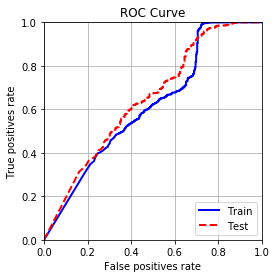

In [32]:
# Create the ROC Curve plot
plot_roc("Train", y_train, train_predictions, color="blue")
plot_roc("Test", y_test, test_predictions, color="red", linestyle="--")
plt.legend(loc="lower right")

 #### Evaluate the Model

In [19]:
# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)

# Define metrics dictionary
metrics = {k: v for k, v in zip(model.metrics_names, scores)}

# Display evaluation metrics results
display(metrics)

{'loss': 0.338189760612887,
 'accuracy': 0.88837206,
 'tp': 1528.0,
 'tn': 0.0,
 'fp': 192.0,
 'fn': 0.0,
 'precision': 0.88837206,
 'recall': 1.0,
 'auc': 0.6090972}

 #### Confusion Matrix

In [21]:
# Define the confusion matrix data
cm_df = pd.DataFrame(
    {
        "Positive (1)": [f"TP={metrics['tp']}", f"FN={metrics['fn']}"],
        "Negative (0)": [f"FP={metrics['fp']}", f"TN={metrics['tn']}"],
    },
    index=["Positive(1)", "Negative(0)"],
)
cm_df.index.name = "Actual"
cm_df.columns.name = "Predicted"

# Show the confusion matrix
cm_df

Predicted   Positive (1) Negative (0)
Actual                               
Positive(1)    TP=1528.0     FP=192.0
Negative(0)       FN=0.0       TN=0.0

 ### Making Predictions

In [25]:
# Make sentiment predictions
predicted = model.predict_classes(X_test[:10])

In [33]:
# Create a DataFrame of Real and Predicted values
sentiments = pd.DataFrame({"Actual": y_test[:10], "Predicted": predicted.ravel()})
sentiments

Actual  Predicted
0       1          1
1       1          1
2       1          1
3       1          1
4       1          1
5       1          1
6       1          1
7       1          1
8       1          1
9       1          1